In [1]:
import cv2
import dlib #used for face detection
import numpy as np
from google.colab.patches import cv2_imshow
import glob

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

from tensorflow.keras.models import Model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split

In [4]:
base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(128,128,3))
model = Model(inputs=base_model.input, outputs=base_model.get_layer('conv_7b').output)
image_size = (128, 128)

features = []
labels   = []
detector = dlib.get_frontal_face_detector()

219070464/219055592 [==============================] - 1s 0us/step


In [ ]:

real_data_list = glob.glob("/content/gdrive/MyDrive/main_proj/real/*.mp4",recursive=True)

fake_data_list = glob.glob("/content/gdrive/MyDrive/main_proj/fake/fake/*.mp4",recursive=True)

res = [0,1]

def preprocess(video_data_list,res):
    for vid in video_data_list[:20]:
        cap = cv2.VideoCapture(vid)
        while True:
            ret, image = cap.read()
            if not ret:
                break
            rects = detector(image, 0)
            for i, d in enumerate(rects):
                x1 = d.left()
                y1 = d.top()
                x2 = d.right()
                y2 = d.bottom()
                crop_img = image[y1:y2, x1:x2]
                try:
                    x = np.expand_dims(crop_img, axis=0)
                    feature = model.predict(x)
                    #print('feature',feature)
                    flat = feature.flatten()
                    features.append(flat)   
                    labels.append(res)
                except:
                    break  
    cv2.destroyAllWindows()
    cap.release()  
    #print(len(features))

preprocess(real_data_list,res[0])

preprocess(fake_data_list,res[1])


In [6]:
X = []
Y = []
for feature in features:
  #print(feature.shape)
  X.append(feature[0:1536]) #X.append(feature[0:6144])

X = np.array(X)
Y = to_categorical(labels,2) 

In [7]:
classifctn_model = Sequential()
classifctn_model.add(Input(shape=(48,32)))
classifctn_model.add(GRU(256, return_sequences=True, activation='tanh'))
classifctn_model.add(GRU(256,activation='tanh'))
classifctn_model.add(Dense(2))

classifctn_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['accuracy'])
classifctn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 48, 256)           222720    
                                                                 
 gru_1 (GRU)                 (None, 256)               394752    
                                                                 
 dense (Dense)               (None, 2)                 514       
                                                                 
Total params: 617,986
Trainable params: 617,986
Non-trainable params: 0
_________________________________________________________________


In [8]:
#Train-Test split
X = X.reshape(-1,48,32)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.1, random_state=5)
#early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=2,verbose=0, mode='auto')
EPOCHS = 20
BATCH_SIZE = 100
history = classifctn_model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_val, Y_val), verbose = 1)

Epoch 1/20
49/49 [==============================] - 29s 522ms/step - loss: 6.2712 - accuracy: 0.5871 - val_loss: 3.5625 - val_accuracy: 0.5881
Epoch 2/20
49/49 [==============================] - 25s 503ms/step - loss: 3.5692 - accuracy: 0.5869 - val_loss: 3.5329 - val_accuracy: 0.5881
Epoch 3/20
49/49 [==============================] - 26s 528ms/step - loss: 3.5447 - accuracy: 0.5869 - val_loss: 3.5169 - val_accuracy: 0.5881
Epoch 4/20
49/49 [==============================] - 27s 547ms/step - loss: 3.5273 - accuracy: 0.5869 - val_loss: 3.5037 - val_accuracy: 0.5881
Epoch 5/20
49/49 [==============================] - 25s 505ms/step - loss: 3.5099 - accuracy: 0.5869 - val_loss: 3.4923 - val_accuracy: 0.5881
Epoch 6/20
49/49 [==============================] - 26s 537ms/step - loss: 3.4951 - accuracy: 0.5869 - val_loss: 3.4824 - val_accuracy: 0.5881
Epoch 7/20
49/49 [==============================] - 25s 503ms/step - loss: 3.4837 - accuracy: 0.5869 - val_loss: 3.4740 - val_accuracy: 0.5881

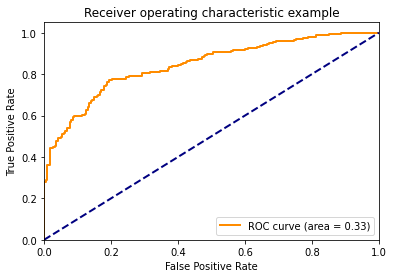

In [9]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc

n_classes = 2
fpr = dict()
tpr = dict()
roc_auc = dict()
pred = classifctn_model.predict(X_val)
#print(Y_val)
#print(pred)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_val[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

import matplotlib.pyplot as plt
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_val.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


In [10]:
#vid = demo
#vid = "/content/gdrive/MyDrive/main_proj/testvid/r/05.mp4"

In [13]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.1 MB 27.7 MB/s 
     |████████████████████████████████| 272 kB 66.8 MB/s 
     |████████████████████████████████| 2.3 MB 48.0 MB/s 
     |████████████████████████████████| 212 kB 69.2 MB/s 
     |████████████████████████████████| 57 kB 5.9 MB/s 
     |████████████████████████████████| 54 kB 3.6 MB/s 
     |████████████████████████████████| 84 kB 3.8 MB/s 
     |████████████████████████████████| 140 kB 61.0 MB/s 
     |████████████████████████████████| 1.1 MB 50.0 MB/s 
     |████████████████████████████████| 144 kB 61.1 MB/s 
     |████████████████████████████████| 94 kB 4.1 MB/s 
     |████████████████████████████████| 271 kB 62.0 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 80 kB 9.8 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 62 kB

In [15]:

def test_video(vid):
  features = []
  detector = dlib.get_frontal_face_detector()
  cap = cv2.VideoCapture(vid)
  while True:
    ret, image = cap.read()
    if not ret:
        break
    rects = detector(image, 0)
    for i, d in enumerate(rects):
        x1 = d.left()
        y1 = d.top()
        x2 = d.right()
        y2 = d.bottom()
        crop_img = image[y1:y2, x1:x2]
        try:
            x = np.expand_dims(crop_img, axis=0)
            feature = model.predict(x)
            flat = feature.flatten()
            features.append(flat)   
        except:
            break  
  cv2.destroyAllWindows()
  cap.release()  

  X = []
  for feature in features:
    X.append(feature[0:1536]) #X.append(feature[0:6144])

  X = np.array(X)
  X = X.reshape(-1, 48, 32)
  predict_x=classifctn_model.predict(X) 
  out_vals = classes_x=np.argmax(predict_x,axis=1)
  for i in out_vals:
    one = 0
    zero = 0 
    if i==1:
      one= one+1
    else:
      zero=zero+1

  if zero>one:
    op="real"
  else:
    op="fake" 
  
  return op

In [16]:
import gradio as gr


def video_flip(vid):
    return video


demo = gr.Interface(test_video, gr.Video(), outputs="text",
    title='DeepFake Video Detection',
    description="Detection of a video whether it's a deepfake or not")

demo.launch()


Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://50553.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<gradio.routes.App at 0x7f8286f94d10>,
 'http://127.0.0.1:7860/',
 'https://50553.gradio.app')

In [17]:
#test_video(vid)

In [18]:

#print(X)